### Installing Required Libraries

In [1]:
pip install numpy pandas matplotlib kaggle seaborn opencv-python random2 statsmodels scikit-image scikit-learn keras-models zipfile36 Pillow joblib tensorflow keras

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

In [2]:
import numpy as np
from numpy import argmax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from kaggle.api.kaggle_api_extended import KaggleApi
from statsmodels.tools import categorical
from skimage.filters import prewitt_h,prewitt_v
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model

import zipfile
from PIL import Image
from sklearn.metrics import plot_confusion_matrix, multilabel_confusion_matrix, roc_auc_score,accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import time


### Setting Variables and Creating Functions

In [3]:
FishCategories = ["Black Sea Sprat", "Gilt-Head Bream", "Hourse Mackerel", "Red Mullet", 
                  "Red Sea Bream", "Sea Bass", "Shrimp","Striped Red Mullet", "Trout"]

#This function downloads the dataset from Kaggle.com and stores it in the working directory
def DownloadDataset():
    
    api = KaggleApi()
    print("Authenticating API")
    api.authenticate()
    print("Downloading Dataset to Working Directory")
    print("This could take a few minutes.")
    api.dataset_download_file("crowww/a-large-scale-fish-dataset", file_name = '')
#    with zipfile.ZipFile(os.path.join(os.getcwd (),'archive.zip'), 'r') as zipref:
#        for file in zipref.namelist():
#            if file.startswith('Fish_Dataset/Fish_Dataset'):
#                archive.extract(file, os.getcwd())
    print("Download Complete")

#This function runs through the zip folder and extracts out the images   
def GetData ():
    RawColor = []
    RawBW = []
    ImageLabel = []
    FishPosition = []
    counter = 0
    print("Getting Images")
    with zipfile.ZipFile(os.path.join(os.getcwd(),'archive.zip'), 'r') as zipref:
        for imagepath in zipref.namelist():
            if (imagepath.__contains__('GT')):
                pass
            elif (imagepath.__contains__('NA_Fish_Dataset')):
                pass
            elif (imagepath.__contains__('png')): #Text was img
                for FishType in FishCategories:
                    if imagepath.__contains__(FishType):
                        fishcategory = FishType
                        FishNumber = FishCategories.index(FishType)
                OriginalImage = Image.open(zipref.open(imagepath))
                OriginalImagePixelBGR = np.array(OriginalImage)
                ImageLabel.append(fishcategory)
                FishPosition.append(FishNumber)
                RawBW.append(cv2.cvtColor(OriginalImagePixelBGR, cv2.COLOR_BGR2GRAY))
               # ResizedImage = Resize(OriginalImagePixelBGR,75,75)
               # ResizedImagePixelBGR = np.array(ResizedImage)
                RawColor.append(OriginalImagePixelBGR)    
                if (counter + 1) % 500==0:
                    print("Retrieved",counter + 1,"Images of 9000")
                elif counter == 0:
                    print("Retrieved",counter,"Images of 9000")
                counter = counter + 1
    return np.array(RawColor), np.array(ImageLabel),np.array(RawBW), np.array(FishPosition)

# Gets the average color value of an image of a given color
def GetColorAverage(ColorNumber):
    col = []
    for c in range(len(ColorImages)):
        ca = np.mean(ColorImages[c][:,:,ColorNumber])
        col.append(ca)
    return np.array(col)

# Gets the average color value of an image at a given percentile for a given color
def GetColorQ(ColorNumber,pct):
    col = []
    for c in range(len(ColorImages)):
        ca = np.array(ColorImages[c][:,:,ColorNumber])
        q = np.percentile(ca, pct)
        col.append(q)
    return np.array(col)

#simple function for resizing images
def Resize(image_,w,h):
    newsize = (w, h)
    return cv2.resize(image_, dsize = newsize)


# Shuffles the position of an array
####def Shuffle(array):
    ######return random.shuffle(array)

# This function gets a random sampling between 1 and 9000. 
def RandomSample(SampleAmount):
    ListRange = range(9000)
    Sample = []
    for i in range(SampleAmount):
        Sample.append(random.choice(ListRange))
    return Sample

#Saves models to the working directory
def SaveFile(Model,FileName):
    Model.save(FileName) 
    print("Saved model to disk")
 
 #Opens a model from the working directory
def OpenFile(FileName):
    return load_model(FileName)

# builds the fitted CNN model
def BuildCNN(ResizeH, ResizeW, BatchSize, Epochs, X, Y,ArrayDepth):
    #GET IMAGE LABELS
    encoder = OneHotEncoder(sparse=False)
    Y_VALUE = pd.DataFrame(Y)
    Y_VALUE = Y_VALUE.astype('category')
    Y_VALUE_CAT = pd.DataFrame(encoder.fit_transform(Y_VALUE)) 
    
    #RESIZES THE IMAGES
    ResizedImages = []
    for i in range(len(X)):
        R_images = Resize(X[i],ResizeH,ResizeW)
        ResizedImages.append(R_images)
    ResizedImages = np.array(ResizedImages)
    
    #TRAIN TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(ResizedImages, Y_VALUE_CAT, test_size=0.33, random_state=42)
    y_test_array = argmax(np.array(y_test), axis=-1).astype('int')
    y_train_array = argmax(np.array(y_train), axis=-1).astype('int')
    
    #CONSTRUCT LAYERS MODEL
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(ResizeH, ResizeW, ArrayDepth)))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())

    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(9, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    #TRAIN MODEL
    model.fit(X_train, y_train, batch_size = BatchSize, epochs = Epochs)
    
    return model, X_test, y_test_array, X_train, y_train_array


#Applies a filtering across the image to remove black and blue color pixels
def ColorFilters(fishImage):
    RedF = (fishImage[:,:,0] > 100)
    InvBlueF = (fishImage[:,:,2] < 115)
    WhiteF = ((fishImage[:,:,0] > 180) & (fishImage[:,:,1] > 180) & (fishImage[:,:,2] > 130))
    BlackF = ((fishImage[:,:,0] < 25) & (fishImage[:,:,1] < 25) & (fishImage[:,:,2] < 25))
    GrayF = (fishImage[:,:,0] < 140) & (fishImage[:,:,1] < 140) & (fishImage[:,:,2] < 140) & (fishImage[:,:,0] > 100) & (fishImage[:,:,1] > 100) & (fishImage[:,:,2] > 100)
    DGrayF = (fishImage[:,:,0] < 100) & (fishImage[:,:,1] < 100) & (fishImage[:,:,2] < 100) & (fishImage[:,:,0] > 80) & (fishImage[:,:,1] > 80) & (fishImage[:,:,2] > 80)
    Filter = (RedF*InvBlueF) + (GrayF + DGrayF + WhiteF + BlackF)

    FilteredImage = fishImage.copy()
    FilteredImage[:, :, 0] = FilteredImage[:, :, 0] * Filter
    FilteredImage[:, :, 1] = FilteredImage[:, :, 1] * Filter
    FilteredImage[:, :, 2] = FilteredImage[:, :, 2] * Filter
    return FilteredImage

#Using the colors below each pixel in every image is classified as one of those colors. From there
#the pixels that are black and blue  are removed from the image and the rest of the colors are 
#counted and totaled so they can be used in the KNN, SVM, and RF
def ClassifyPixelColor(width, height):
    ColorLabels = ['Red','Orange','Brown','Tan','Blue', 'LightBlue','Gray', 'White','Black']
    np.array(ColorLabels)
    ColorValues = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[75,75,200],[165,165,165],[125,125,125],[235,235,235],[20,20,20]]
    ColorValuesMap = [[200,75,75], [200,125,75], [151,122,83], [217,171,118],[20,20,20],[20,20,20],[20,20,20],[235,235,235],[20,20,20]]
    w = width
    h = height
    zeros = np.zeros(9, dtype=int)
    dim = (w,h)
    totals = []
    ModifiedImages = []
    for i in range(9000):
        if i % 1000 == 0:
            print("Images Processed:", i)
        Reshaped = np.reshape(cv2.resize(ColorImages[i], dim),(w*h,3))
        ColorLabels = np.array(ColorLabels)
        zeros = np.zeros(9, dtype=int)
        for p in range(w*h):
            Dif = np.array(np.sum(abs(Reshaped[p]-ColorValues), axis = 1))
            Current = 1000
            Color=''
            for c in range(len(ColorLabels)):
                if Dif[c] < Current:
                    Color = ColorValuesMap[c]
                    Current = Dif[c]
            zeros[ColorValuesMap.index(Color)] = zeros[ColorValuesMap.index(Color)] + 1
            Reshaped[p] = Color
        totals.append(zeros)
        ModifiedImages.append(np.reshape(Reshaped,(h,w,3)))
    totals = np.array(totals)
    totals = pd.DataFrame(totals)
    totals.columns = ["Reds", "Oranges", "Browns", "Tans", "Blues", "LightBlues", "Grays", "Whites", "Blacks"]
    totals = totals[["Reds", "Oranges", "Browns", "Tans", "Grays","Whites"]]
    return totals, np.array(ModifiedImages)

# builds a multiclass confusion matrix
def ConfusionMatrix(yt, yh,FileName): 
    CM = np.zeros((len(FishCategories), len(FishCategories)))
    for i in range(len(yt)):
        AP = yt[i]
        PP = yh[i]
        CM[AP][PP] = CM[AP][PP] + 1
    s = sns.heatmap(CM, 
                linewidth=0.5,
                square=True, 
                cmap='viridis',
                annot=True,
                fmt= '.0f',
                xticklabels=FishCategories, 
                yticklabels=FishCategories)
    s.set(xlabel='Predicted', ylabel='Actual')
    results_path = str(FileName)
    plt.savefig(results_path)
    plt.show()
    return CM

def GetRocGraphValues(CM):

    for thresh in np.linspace(0, 1, 100):
        TP = 0
        FP = 0
        for col in range(9):
            TP = TP + RFCM[col][col]
            for row in range(9):
                if row > col:
                    FP = FP + CM[row][col]
        tpr = TP/(TP+FP)
        fpr = FP/(FP+TP)
    return tpr, fpr 

### Getting Images

In [4]:
#If the zip file of the images is found in the working directory, then it will start pulling it into 
#python otherwise it will download the dataset and pull it into memory

if os.path.exists(os.path.join(os.getcwd (),'archive.zip')):
    pass
else:
    DownloadDataset()
ColorImages, ImageLabels, GrayImage, FishPosition = GetData() 


Getting Images
Retrieved 0 Images of 9000
Retrieved 500 Images of 9000
Retrieved 1000 Images of 9000
Retrieved 1500 Images of 9000
Retrieved 2000 Images of 9000
Retrieved 2500 Images of 9000
Retrieved 3000 Images of 9000
Retrieved 3500 Images of 9000
Retrieved 4000 Images of 9000
Retrieved 4500 Images of 9000
Retrieved 5000 Images of 9000
Retrieved 5500 Images of 9000
Retrieved 6000 Images of 9000
Retrieved 6500 Images of 9000
Retrieved 7000 Images of 9000
Retrieved 7500 Images of 9000
Retrieved 8000 Images of 9000
Retrieved 8500 Images of 9000
Retrieved 9000 Images of 9000


### Data Exploration

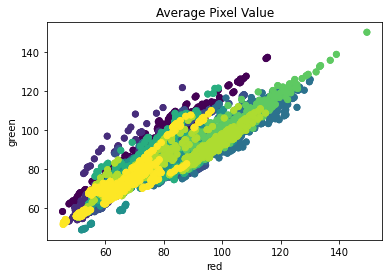

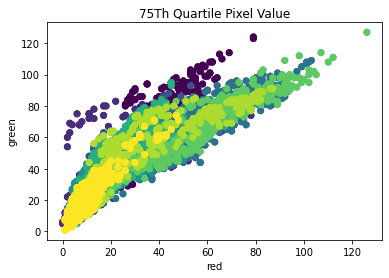

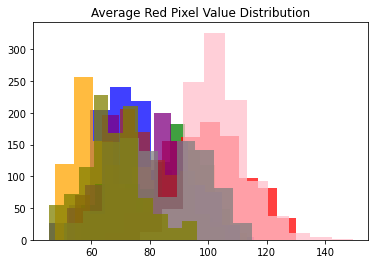

In [5]:
# Data Exploration----Comparing pixel colors across images across classification groups
n = 0
Colors = ['blue','orange','green','red','purple','brown','pink','gray','olive']
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index,GetColorAverage(0),GetColorAverage(1),GetColorAverage(2), GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25),GetColorQ(0,25), GetColorQ(1,25), GetColorQ(2,25)]
ColorDimDt = pd.DataFrame(columns = ('FishPosition','RedAvg','GreenAvg','BlueAvg','Red25Q','Green25Q','Blue25Q','Red75Q','Green75Q','Blue75Q'))
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))


plt.scatter(ColorDimDt[1],ColorDimDt[2],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("Average Pixel Value")
plt.show()

plt.scatter(ColorDimDt[4],ColorDimDt[5],c = ColorDimDt[0])
plt.xlabel("red")
plt.ylabel("green")
plt.title("75Th Quartile Pixel Value")
plt.show()

for i in range(9):
    plt.hist(ColorDimDt[ColorDimDt[0]==i][1],color = Colors[i],alpha = .75)
    plt.title("Average Red Pixel Value Distribution")
plt.show()

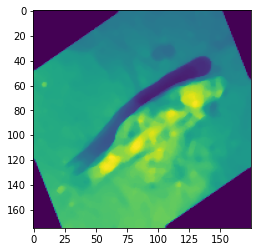

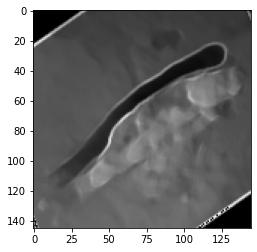

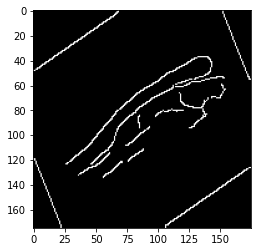

In [6]:
# Feature extraction. Finding ways to isolate the fish's edges

resize = 175
cropl = 15
croph = resize-15
Resized = GrayImage[3500]
Resized = Resize(Resized, resize,resize)
Resized = cv2.medianBlur(Resized, 5)
Resized = cv2.medianBlur(Resized, 5)


#plt.imshow(Resized,cmap='gray')
#define the vertical filter
E = [[-1,0,1], [-2,0,2], [-1,0,1]]
NE = [[0,1,2], [-1,0,1], [-2,1,0]]
N = [[1,2,1], [0,0,0], [-1,-2,-1]]
NW = [[2,1,0], [1,0,-1], [0,-1,-2]]
W = [[-1,0,1], [2,0,-2], [1,0,-1]]
SW = [[0,-1,-2], [1,0,-1],[2,-1,0]]
S = [[-1,-2,-1], [0,0,0],[1,2,1]]
SE = [[-2,-1,0], [-1,0,1],[0,1,2]]


#read in the pinwheel image
img = Resized

#get the dimensions of the image
n,m = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2]
        East = E*local_pixels
        West = W*local_pixels
        North = N*local_pixels
        South = S*local_pixels
        NorthEast = NE*local_pixels
        NorthWest = NW*local_pixels
        SouthEast = SE*local_pixels
        SouthWest = SW*local_pixels
        
        Escore = East.sum()/4
        Wscore = West.sum()/4
        Nscore = North.sum()/4
        Sscore = South.sum()/4        
        NEscore = NorthEast.sum()/4
        NWscore = NorthWest.sum()/4
        SEscore = SouthEast.sum()/4
        SWscore = SouthWest.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (Escore**2+Wscore**2+Nscore**2+Sscore**2+ NEscore**2+ NWscore**2 +SEscore**2+SWscore**2)**.5
        
        #insert this edge score into the edges image
        edges_img[row, col] = edge_score

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(Resized)
plt.show()
Crop = edges_img[range(cropl,croph),:]
Crop = Crop[:,range(cropl,croph)]
plt.imshow(Crop, cmap = "gray")
plt.show()
edges = cv2.Canny(Resized,100,200)
plt.imshow(edges, cmap = 'gray')

### Pre-Processing and Model Training for CNN

In [7]:
TimeToTrain = []
start = time.time()
CNNFitted,CNNX_test, CNNY_test_label,CNNX_train,CNNY_train_label = BuildCNN(75,75,35,7,ColorImages,ImageLabels,3)
end = time.time()
TimeToTrain.append(["CNN","Preprocessing and Training",end - start])
SaveFile(CNNFitted,'CNNModel.h5')


Epoch 1/7
173/173 [==============================] - 54s 308ms/step - loss: 2.8946 - accuracy: 0.2668
Epoch 2/7
173/173 [==============================] - 56s 325ms/step - loss: 1.4068 - accuracy: 0.4871
Epoch 3/7
173/173 [==============================] - 53s 304ms/step - loss: 0.8034 - accuracy: 0.7176
Epoch 4/7
173/173 [==============================] - 53s 305ms/step - loss: 0.4120 - accuracy: 0.8605
Epoch 5/7
173/173 [==============================] - 52s 298ms/step - loss: 0.2558 - accuracy: 0.9100
Epoch 6/7
173/173 [==============================] - 56s 326ms/step - loss: 0.1950 - accuracy: 0.9340
Epoch 7/7
173/173 [==============================] - 54s 314ms/step - loss: 0.0958 - accuracy: 0.9672
Saved model to disk


### Getting CNN Results

CNN
0.9195286195286195


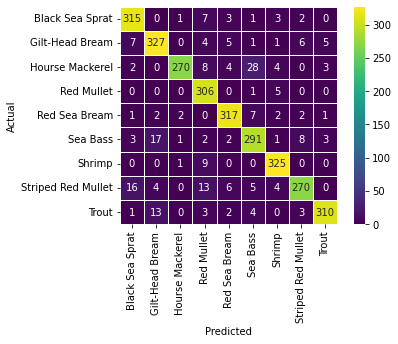

0.9954765384483019

In [8]:
# Saving CNN Model
CNNFitted = OpenFile('CNNModel.h5')
start = time.time()
PredictedPercent = CNNFitted.predict(CNNX_test)
end = time.time()
TimeToTrain.append(["CNN","Predicting",end - start])
CNNyhat = argmax(PredictedPercent, axis=-1).astype('int')
print("CNN")

PredictedPercentTrain = CNNFitted.predict(CNNX_train)
CNNyhatTrain = argmax(PredictedPercentTrain, axis=-1).astype('int')

CNNTTrainingAccuracy = accuracy_score(CNNyhatTrain,CNNY_train_label)
CNNTTestingAccuracy = accuracy_score(CNNyhat,CNNY_test_label)
print(accuracy_score(CNNyhat,CNNY_test_label))
CNNCM=ConfusionMatrix(CNNY_test_label, CNNyhat,"ConfusionMatrix_CNN.png")
CNN_ROC_Score = roc_auc_score(CNNY_test_label, PredictedPercent, multi_class='ovr')
CNN_ROC_Score

### Pre-Processing for KNN, SVM, and Random Forest

In [9]:
# Pre-Processing for KNN, SVM, and Random Forest
StartPreProcessing = time.time()
Counts, NewImage = ClassifyPixelColor(50, 50)    
EndPreProcessing = time.time()

Images Processed: 0
Images Processed: 1000
Images Processed: 2000
Images Processed: 3000
Images Processed: 4000
Images Processed: 5000
Images Processed: 6000
Images Processed: 7000
Images Processed: 8000


### KNN, SVM, and Random Forest Training and Model Results

KNN
0.9838383838383838


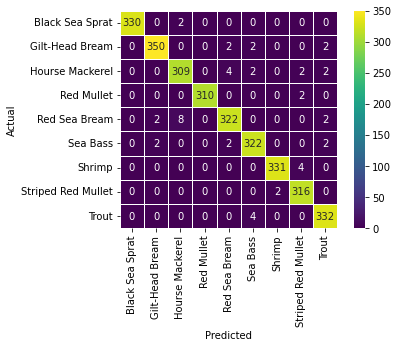

SVM
0.9542087542087542


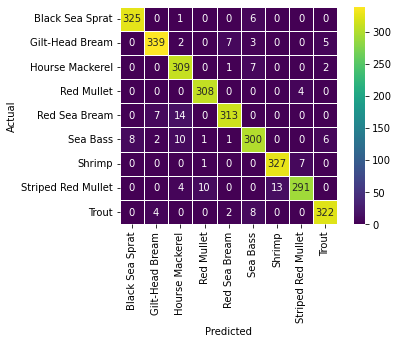

Random Forest
0.9794612794612795


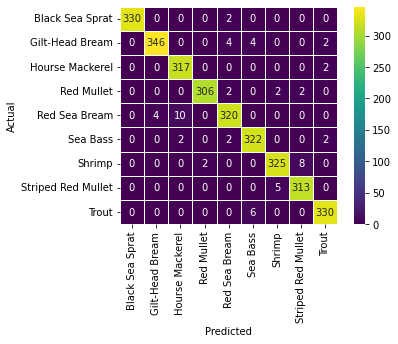

In [10]:
#Getting the Y labels for the KNN, SVM, and Random Forest models
n = 0
index = []
for j in range(9):
    for i in range(1000):
         index.append(n)
    n = n+1
ColorDim = [index]
ColorDimDt = pd.DataFrame(np.transpose(ColorDim))

X_train, X_test, y_train, y_test = train_test_split(Counts[["Reds", "Oranges", "Browns", "Tans", "Grays","Whites"]][:],
                                                    ColorDimDt[0], test_size=0.33, random_state=42)
y_test = np.array(y_test).astype('int')

#KNN
StartTrainingKNN = time.time()
KNN = KNeighborsClassifier(n_neighbors=1)
KNNFitted = KNN.fit(X_train, y_train)
EndTrainingKNN = time.time()
TimeToTrain.append(["KNN","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing) + 
                    (EndTrainingKNN-StartTrainingKNN)])
joblib.dump(KNNFitted, "KNNModel.joblib")
print("KNN")
knnTrainingAccuracy = KNNFitted.score(X_train,y_train)
KnnTestedAccuracy = KNNFitted.score(X_test,y_test)
print(KNNFitted.score(X_test,y_test))


start = time.time()
KNNYhat = np.array(KNNFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["KNN","Predicting",(end - start)])
KNNCM = ConfusionMatrix(y_test, KNNYhat,"ConfusionMatrix_KNN.png")
KNN_ROC_Score = roc_auc_score(y_test, KNNFitted.predict_proba(X_test), multi_class='ovr')


#SVM
SVM = SVC(kernel = 'rbf', C=10000,decision_function_shape='ovr',probability = True)
StartTrainingSVM = time.time()
SVMFitted = SVM.fit(X_train, y_train)
EndTrainingSVM = time.time()
TimeToTrain.append(["SVM","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing)+
                    (EndTrainingSVM-StartTrainingSVM)])
joblib.dump(SVMFitted, "SVMModel.joblib")
print("SVM")
SVMTrainingAccuracy = SVMFitted.score(X_train,y_train)
SVMTestedAccuracy = SVMFitted.score(X_test,y_test)
print(SVMFitted.score(X_test,y_test))

start = time.time()
SVMYhat = np.array(SVMFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["SVM","Predicting",(end - start)])
SVMCM = ConfusionMatrix(y_test, SVMYhat,"ConfusionMatrix_SVM.png")
SVM_ROC_Score = roc_auc_score(y_test, SVMFitted.predict_proba(X_test), multi_class='ovr')


#Random Forest
RF = RandomForestClassifier(n_estimators=100, 
                            min_samples_split = 5, 
                            min_samples_leaf=2,
                            max_features = 'sqrt',
                            bootstrap = False)
StartTrainingRF = time.time()
RFFitted = RF.fit(X_train, y_train)
EndTrainingRF = time.time()
TimeToTrain.append(["RF","Preprocessing and Training",
                    (EndPreProcessing - StartPreProcessing)+
                    (EndTrainingRF-StartTrainingRF)])
joblib.dump(RFFitted, "RFModel.joblib")
print("Random Forest")
RFTrainingAccuracy = RFFitted.score(X_train,y_train)
RFTestedAccuracy = RFFitted.score(X_test,y_test)
print(RFFitted.score(X_test,y_test))

start = time.time()
RFYhat = np.array(RFFitted.predict(X_test)).astype('int')
end = time.time()
TimeToTrain.append(["RF","Predicting",(end - start)])
RFCM = ConfusionMatrix(y_test, RFYhat,"ConfusionMatrix_RF.png")
RF_ROC_Score = roc_auc_score(y_test, RFFitted.predict_proba(X_test), multi_class='ovr')



### Build ROC Plot

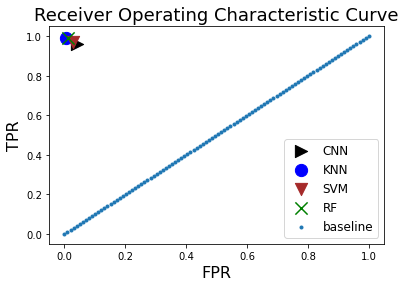

In [27]:
fig, ax = plt.subplots()
CNNtpr,CNNfpr = GetRocGraphValues(CNNCM)
KNNtpr,KNNfpr = GetRocGraphValues(KNNCM)
SVMtpr,SVMfpr = GetRocGraphValues(SVMCM)
RFtpr,RFfpr = GetRocGraphValues(RFCM)
ax.scatter(CNNfpr, CNNtpr, color = 'black',marker = '>', s = 150,label = 'CNN')
ax.scatter(KNNfpr, KNNtpr, color = 'blue',marker = 'o', s = 150,label = 'KNN')
ax.scatter(SVMfpr, SVMtpr, color = 'brown',marker = 'v', s = 150,label = 'SVM')
ax.scatter(RFfpr, RFtpr, color = 'green',marker = 'x', s = 150,label = 'RF')
ax.scatter(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         marker = '.')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)
rp = str("ROC-AUC.png")
plt.savefig(rp);    

### Building Results Table

In [12]:
TimeDataFrame = pd.DataFrame(np.array(TimeToTrain))
TimeDataFrame.columns = ["Model","TimeType","Time (Seconds)"]
TimeDataFrame
Predicting = TimeDataFrame[TimeDataFrame["TimeType"]=='Predicting']["Time (Seconds)"]
Training = TimeDataFrame[TimeDataFrame["TimeType"]=='Preprocessing and Training']["Time (Seconds)"]
TrainingAccuracy = [CNNTTrainingAccuracy, knnTrainingAccuracy, SVMTrainingAccuracy, RFTrainingAccuracy]
TestingAccuracy = [CNNTTestingAccuracy, KnnTestedAccuracy, SVMTestedAccuracy, RFTestedAccuracy]
ROC = [CNN_ROC_Score, KNN_ROC_Score,SVM_ROC_Score, RF_ROC_Score]
TimeDataFrameClean = pd.DataFrame(np.transpose(np.array([['CNN',"KNN","SVM","RF"],TrainingAccuracy, TestingAccuracy, Training,Predicting, ROC])))
TimeDataFrameClean.columns = ["Model","Training Accuracy","Testing Accuracy","Preprocessing and Training (Sec)", "Predicting 2,970 Images (Sec)","ROC-AUCScore"]
TimeDataFrameClean



,Model,Training Accuracy,Testing Accuracy,Preprocessing and Training (Sec),"Predicting 2,970 Images (Sec)",ROC-AUCScore
0,CNN,0.976949,0.919529,378.8259994983673,6.653153896331787,0.995477
1,KNN,1.0,0.983838,465.4250965118408,0.09474945068359375,0.990935
2,SVM,0.974129,0.954209,476.6316900253296,0.536933183670044,0.998089
3,RF,0.999834,0.979461,466.1336543560028,0.06386303901672363,0.999572


### Tuning Hyper Parameters

1 :  1.0   0.9838383838383838
2 :  0.9950248756218906   0.9723905723905724
3 :  0.9920398009950249   0.9649831649831649
4 :  0.9825870646766169   0.9653198653198654
5 :  0.9829187396351575   0.9686868686868687
6 :  0.9814262023217247   0.9663299663299664
7 :  0.9799336650082918   0.9646464646464646
8 :  0.9771144278606965   0.9636363636363636
9 :  0.9723051409618574   0.9592592592592593
10 :  0.9709784411276948   0.9572390572390572
11 :  0.9689883913764511   0.9545454545454546
12 :  0.9676616915422885   0.9518518518518518
13 :  0.9640132669983417   0.9471380471380472
14 :  0.9626865671641791   0.9457912457912457
15 :  0.958374792703151   0.9424242424242424
16 :  0.9587064676616915   0.9383838383838384
17 :  0.9560530679933665   0.935016835016835
18 :  0.9550580431177446   0.932996632996633
19 :  0.951077943615257   0.9276094276094277
20 :  0.9482587064676616   0.9245791245791246
21 :  0.9467661691542288   0.9188552188552188
22 :  0.9384742951907131   0.9161616161616162
23 :  0.93283582

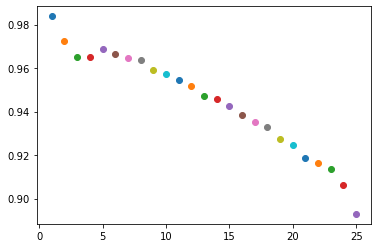

In [13]:
#KNN Grid Search
for k in range(25):
    KNN = KNeighborsClassifier(n_neighbors=k+1)
    KNNFitted = KNN.fit(X_train, y_train)
    knnTrainingAccuracy = KNNFitted.score(X_train,y_train)
    KnnTestedAccuracy = KNNFitted.score(X_test,y_test)
    print(k+1,': ',knnTrainingAccuracy,' ',KnnTestedAccuracy)
    plt.scatter(k+1,KnnTestedAccuracy)
plt.show()

1   rbf   0.1 :  0.9741293532338309   0.9703703703703703
1   rbf   1 :  0.9741293532338309   0.9703703703703703
1   rbf   10 :  0.9741293532338309   0.9703703703703703
1   rbf   100 :  0.9741293532338309   0.9703703703703703
1   rbf   1000 :  0.9741293532338309   0.9703703703703703
rbf


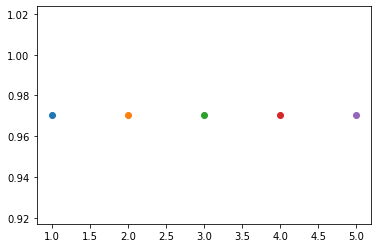

[1, ' ', 'rbf', ' ', 0.1, ': ', 0.9741293532338309, ' ', 0.9703703703703703]
0.1   rbf   0.1 :  0.9741293532338309   0.9703703703703703
0.1   rbf   1 :  0.9741293532338309   0.9703703703703703
0.1   rbf   10 :  0.9741293532338309   0.9703703703703703
0.1   rbf   100 :  0.9741293532338309   0.9703703703703703
0.1   rbf   1000 :  0.9741293532338309   0.9703703703703703
rbf


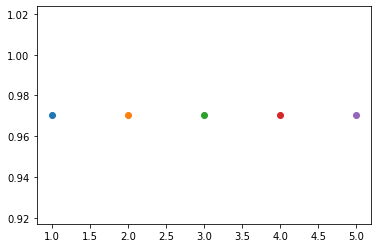

[1, ' ', 'rbf', ' ', 0.1, ': ', 0.9741293532338309, ' ', 0.9703703703703703]
0.01   rbf   0.1 :  0.9741293532338309   0.9703703703703703
0.01   rbf   1 :  0.9741293532338309   0.9703703703703703
0.01   rbf   10 :  0.9741293532338309   0.9703703703703703
0.01   rbf   100 :  0.9741293532338309   0.9703703703703703
0.01   rbf   1000 :  0.9741293532338309   0.9703703703703703
rbf


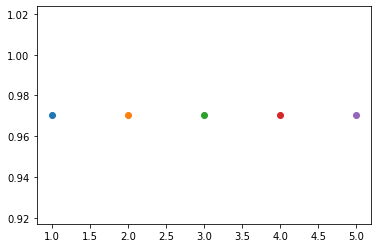

[1, ' ', 'rbf', ' ', 0.1, ': ', 0.9741293532338309, ' ', 0.9703703703703703]
0.001   rbf   0.1 :  0.9741293532338309   0.9703703703703703
0.001   rbf   1 :  0.9741293532338309   0.9703703703703703
0.001   rbf   10 :  0.9741293532338309   0.9703703703703703
0.001   rbf   100 :  0.9741293532338309   0.9703703703703703
0.001   rbf   1000 :  0.9741293532338309   0.9703703703703703
rbf


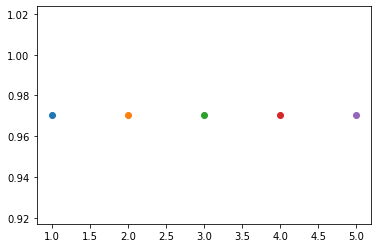

[1, ' ', 'rbf', ' ', 0.1, ': ', 0.9741293532338309, ' ', 0.9703703703703703]
0.0001   rbf   0.1 :  0.9741293532338309   0.9703703703703703
0.0001   rbf   1 :  0.9741293532338309   0.9703703703703703
0.0001   rbf   10 :  0.9741293532338309   0.9703703703703703
0.0001   rbf   100 :  0.9741293532338309   0.9703703703703703
0.0001   rbf   1000 :  0.9741293532338309   0.9703703703703703
rbf


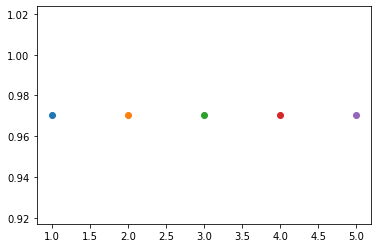

[1, ' ', 'rbf', ' ', 0.1, ': ', 0.9741293532338309, ' ', 0.9703703703703703]


In [14]:
#SVM Hyper Parameters
scaler = MinMaxScaler()
scaler.fit(X_train)
#SVM Grid Search
gammas = [1, 0.1, 0.01, 0.001, 0.0001]
kernals = ['rbf']
cs = [0.1, 1, 10, 100, 1000]
acc = 0 
for g in gammas:
    for kern in kernals:
        i = 1
        for c in cs:
            SVM = SVC(kernel = 'rbf', C=1, gamma = 1000,decision_function_shape='ovr',max_iter = 3000)
            SVMFitted = SVM.fit(scaler.transform(X_train), y_train)
            SVMTestedAccuracy = SVMFitted.score(scaler.transform(X_test),y_test)
            print(g,' ',kern,' ',c,': ',SVMTrainingAccuracy,' ',SVMTestedAccuracy)
            plt.scatter(i,SVMTestedAccuracy)
            i = i + 1
            if SVMTestedAccuracy > acc:
                acc = SVMTestedAccuracy
                new = [g,' ',kern,' ',c,': ',SVMTrainingAccuracy,' ',SVMTestedAccuracy]
        print(kern)
        plt.show() 
        print(new)

In [15]:
#Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
RF = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2,
                               random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_estimator_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1757)

### Understanding incorrectly classified images

C:\Users\ddegroot\AppData\Local\Temp\1/ipykernel_5832/1846228051.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
C:\Users\ddegroot\AppData\Local\Temp\1/ipykernel_5832/1846228051.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+


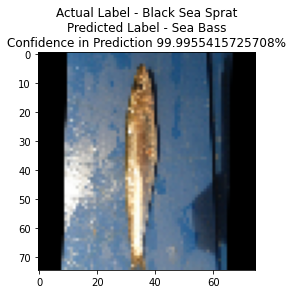

In [16]:
#Incorrect CNN Classifications
fishnumber = 10

IncorrectlyLabeled = []
for i in range(len(CNNY_test_label)):
    if CNNY_test_label[i] != CNNyhat[i]:
        IncorrectlyLabeled.append([CNNY_test_label[i],CNNyhat[i],CNNX_test[i]])


plt.imshow(np.array(IncorrectlyLabeled)[fishnumber][2])
plt.title('Actual Label - '+str(FishCategories[np.array(IncorrectlyLabeled)[fishnumber][0]])+'\n'+
          'Predicted Label - '+str(FishCategories[IncorrectlyLabeled[fishnumber][1]])+'\n'+
          'Confidence in Prediction ' +str(max(PredictedPercent[i]).astype('float')*100)+'%')    
plt.show()

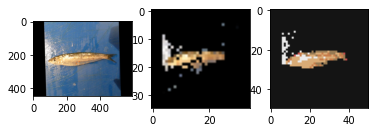

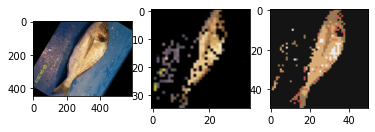

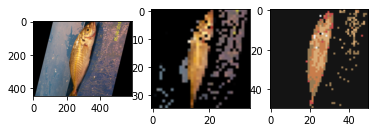

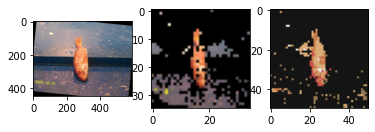

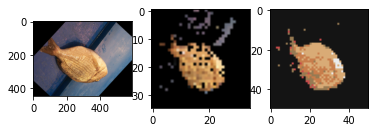

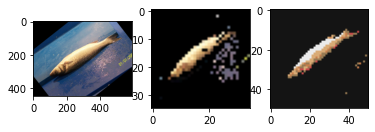

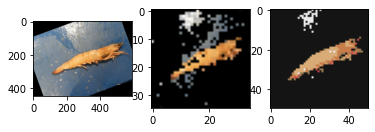

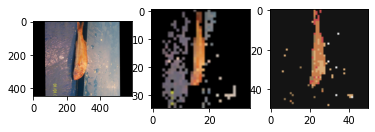

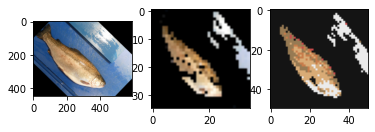

In [17]:
fishlist = [234,1948,2034,3203,4093,5932,6905,7002,8094]
PixelColorCounts = []
for i in fishlist:
    img = NewImage[i]
    NewImage = NewImage.astype(int)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(ColorImages[i])
    axarr[1].imshow(ColorFilters(Resize(ColorImages[i],35,35)))
    axarr[2].imshow(img)        


(48, 6)
FishNumber:8932


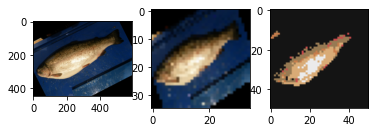

FishNumber:2164


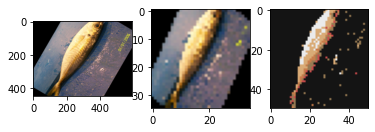

FishNumber:6489


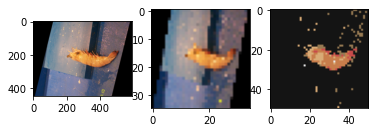

FishNumber:4623


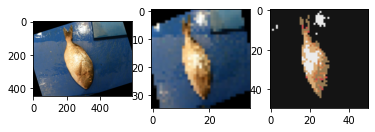

FishNumber:4630


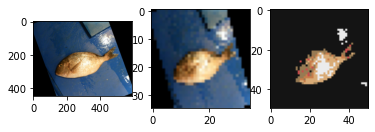

FishNumber:5508


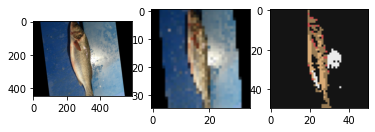

FishNumber:4113


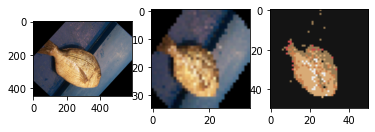

FishNumber:8485


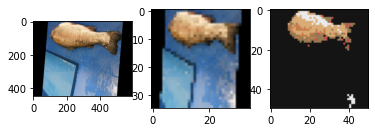

FishNumber:1147


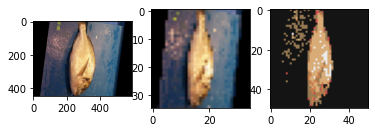

FishNumber:5509


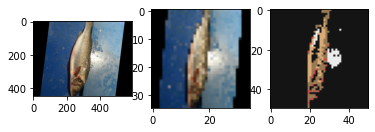

FishNumber:2996


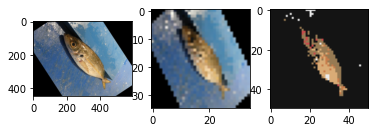

FishNumber:4900


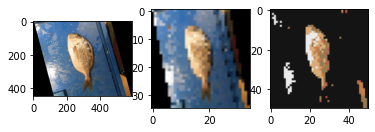

FishNumber:2865


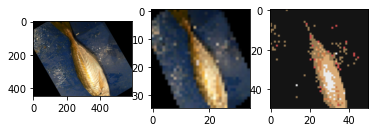

FishNumber:6716


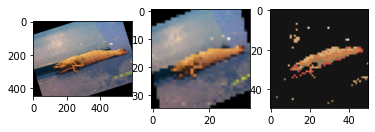

FishNumber:4638


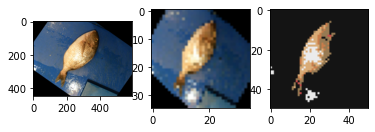

FishNumber:1075


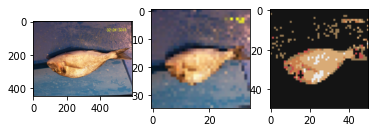

FishNumber:5635


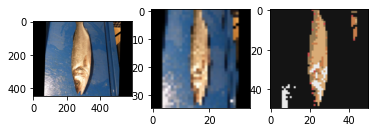

FishNumber:8933


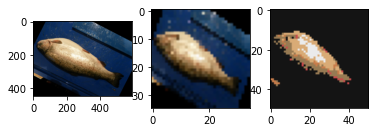

FishNumber:6717


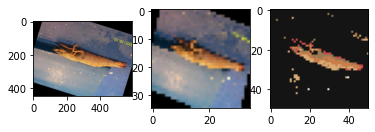

FishNumber:230


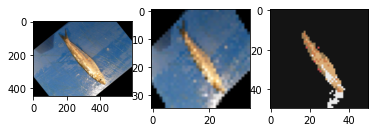

FishNumber:1193


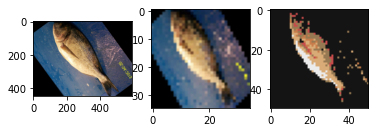

FishNumber:5620


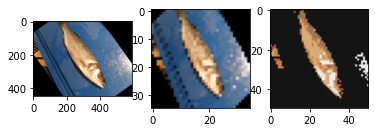

FishNumber:2165


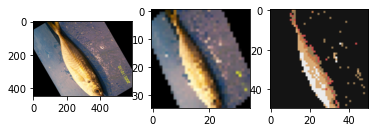

FishNumber:7362


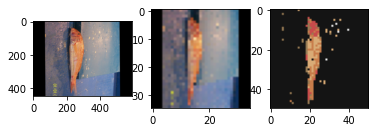

FishNumber:2404


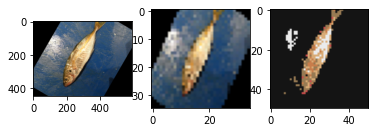

In [26]:
IncorrectRF = X_test[y_test != KNNYhat]
print(IncorrectRF.shape)
PixelColorCounts = []
for i in range(25):
    c = IncorrectRF.index[i]
    img = NewImage[c]
    print("FishNumber:" + str(c))
    NewImage = NewImage.astype(int)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(ColorImages[c])
    axarr[1].imshow(Resize(ColorImages[c],35,35))
    axarr[2].imshow(img) 
    plt.show()
